In [1]:
import os
import datetime

import numpy as np
import scipy
import fiona
import statistics
import math

import pandas as pd
import geopandas as gpd
from shapely import wkt
from shapely.geometry import LineString, shape, mapping, Point, Polygon, MultiPolygon
from shapely.ops import cascaded_union

from scipy.stats import linregress

import matplotlib.pyplot as plt
from matplotlib import colors, cm, style
import matplotlib.patches as mpatches
from descartes import PolygonPatch
from matplotlib.colors import LinearSegmentedColormap

import osmnx as ox
import networkx as nx

In [2]:
from my_area_stats import val_per_area

In [3]:
style.use('seaborn-white')
input_output_folder = 'data'
osm_crs = 'EPSG:3857'

# Parameters

In [17]:
# Place                                Country              CRS
# Amsterdam | Rotterdam | The Hague    (The Netherlands)    EPSG:28992
# Madrid    | Barcelona | Valencia     (Spain)              EPSG:25830
# Stockholm | Goteborg  | Malmo        (Sweden)             EPSG:3006 ???

place_name = 'The Hague'
local_crs = 'EPSG:28992'
sub_folder = str(place_name).replace(' ', '')+'_14Apr2022'
country = 'NLD'

In [18]:
trip_distances = [300, 500, 800]
trip_colors = ['#78c679', '#c2e699', '#ffffcc']

children = True

betw_radius = 800

# Load data

In [19]:
place = gpd.read_file(os.path.join(input_output_folder, sub_folder, 'place.geojson'))
place.crs = local_crs

In [20]:
greenspaces = gpd.read_file(os.path.join(input_output_folder, sub_folder, 'greenspaces.geojson'))
greenspaces.crs = local_crs

In [21]:
residences = gpd.read_file(os.path.join(input_output_folder, sub_folder, 'residences_population.geojson'))
residences.crs = local_crs

residences['pop_count'] = residences['pop_count'].astype(float)
if country == 'NLD' and children:
    residences['cld_count'] = residences['cld_count'].astype(float)
    residences['adl_count'] = residences['adl_count'].astype(float)

In [22]:
educational_cld = gpd.read_file(os.path.join(input_output_folder, sub_folder, 'education_children.geojson'))
educational_cld.crs = local_crs

In [23]:
educational_adl = gpd.read_file(os.path.join(input_output_folder, sub_folder, 'education_adolescents.geojson'))
educational_adl.crs = local_crs

In [24]:
paths_file = os.path.join(input_output_folder, sub_folder, 'betw_{}_complete.geojson'.format(str(betw_radius)))
paths = gpd.read_file(paths_file)
paths.crs = local_crs

paths['betw_cld_800_dr12'] = paths['betw_cld_800_dr12'].astype(float)
paths['betw_adl_800_dr12'] = paths['betw_adl_800_dr12'].astype(float)
paths['length'] = paths.geometry.length    

In [25]:
place = gpd.read_file(os.path.join(input_output_folder, sub_folder, 'place.geojson'))
place.crs = local_crs

In [26]:
def set_types_geometries(df, cols):
    for col in cols:
        df[col] = df[col].apply(wkt.loads)
        gdf = gpd.GeoDataFrame(df, geometry=col)
        gdf.crs = local_crs

In [27]:
cols = []
for trip_dist in trip_distances:
    cols.append('geom_iso_'+str(trip_dist))

set_types_geometries(greenspaces, cols)

In [28]:
trip_labels = []
for trip_distance in trip_distances:
    trip_labels.append('Within {}m walk'.format(trip_distance))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


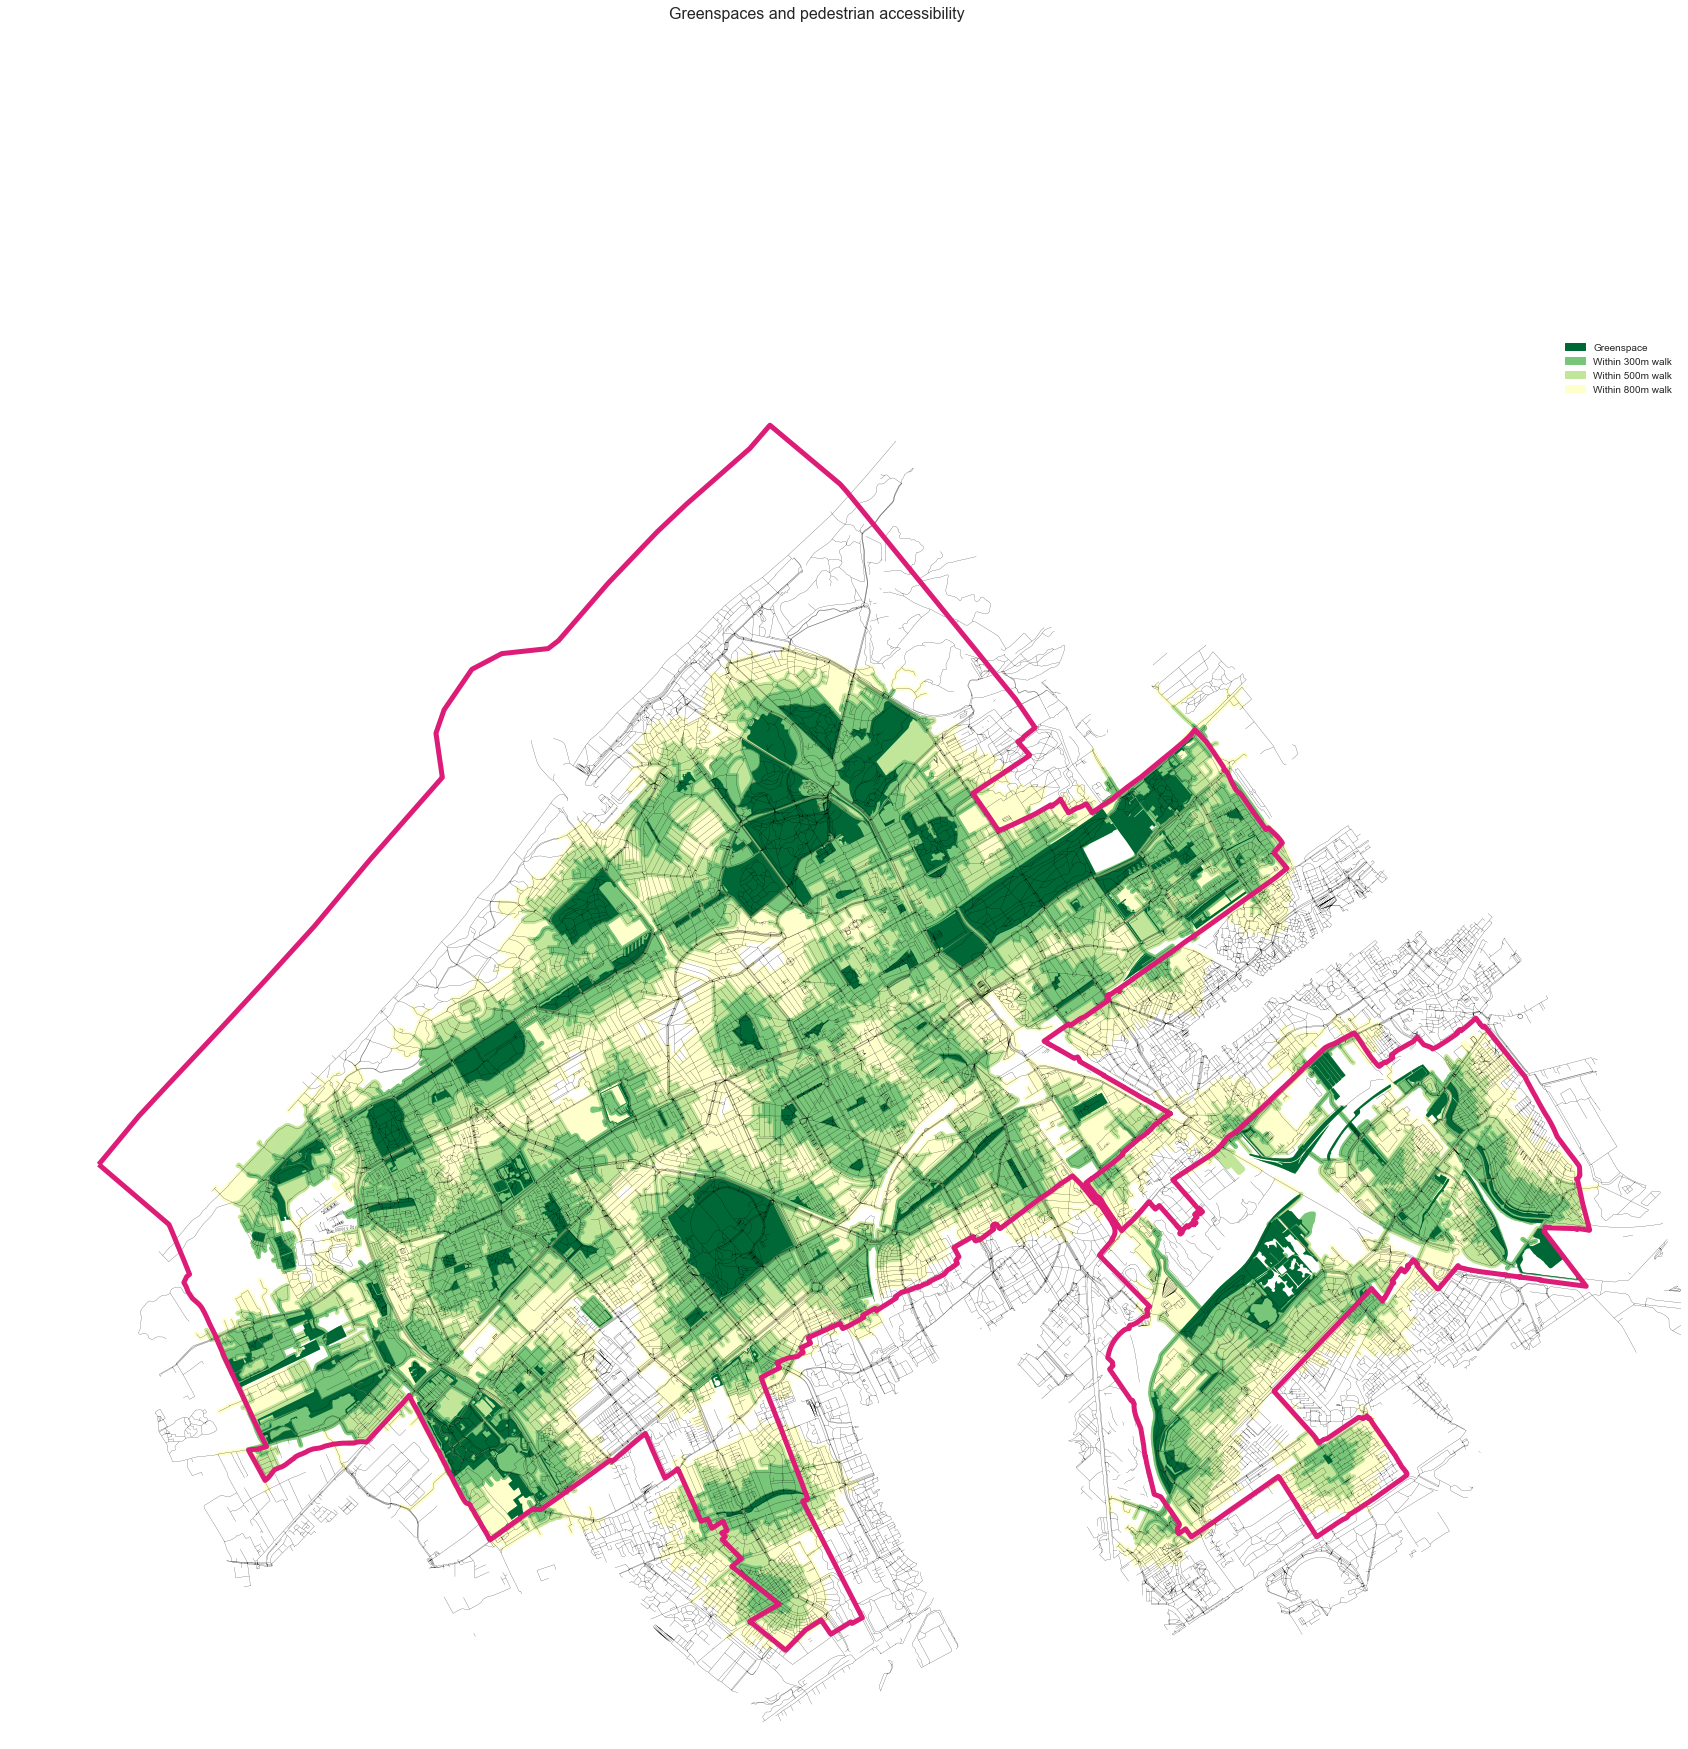

In [29]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(30,30))
fig.suptitle('Greenspaces and pedestrian accessibility', fontsize=16)

bbox = place.total_bounds
margin = 1000
xlim = ([bbox[0]-margin, bbox[2]+margin])
ylim = ([bbox[1]-margin, bbox[3]+margin])
axs.set_xlim(xlim)
axs.set_ylim(ylim)

for i in range(len(trip_distances)):
    greenspaces.set_geometry(('geom_iso_'+str(trip_distances[i]))).plot(ax=axs, color=trip_colors[i], zorder=len(trip_distances)-i)
greenspaces.plot(ax=axs, figsize=(12, 20), color='#006837', zorder=4) 
paths.plot(ax=axs, figsize=(12, 20), color='black', linewidth=0.2, zorder=5)
place.plot(ax=axs, figsize=(12, 20), facecolor='none', edgecolor='#dd1c77', linestyle='-', linewidth=5, zorder=6)

gs = mpatches.Patch(color='#006837', label='Greenspace')
handles = [gs]
for i in range(len(trip_distances)):
    handles.append(mpatches.Patch(color=trip_colors[i], label=trip_labels[i]))
plt.legend(loc='upper right')
plt.legend(handles=handles)

plt.axis('off')
plt.show()

# Calculate

In [17]:
greenspaces['index'] = greenspaces.index

## Residential static approach

In [18]:
if 'index_right' in residences.columns:
    residences.drop(columns='index_right', inplace=True)

In [19]:
modes = ['sum']
value_cols = ['pop_count', 'cld_count', 'adl_count']

for trip_distance in trip_distances:
    greenspaces = greenspaces.set_geometry('geom_iso_{}'.format(trip_distance))
    
    for value_col in value_cols:
        greenspaces = val_per_area(greenspaces, 'index', residences, modes=modes, value_col=value_col)

        for mode in modes:
            greenspaces.rename(columns={value_col+'_'+mode: value_col+'_'+mode+'_'+str(trip_distance)}, inplace=True)

In [20]:
for trip_distance in trip_distances:
    for value_col in value_cols:
        for mode in modes:
            rank_col = "{}_{}_{}_rank".format(value_col, mode, trip_distance)
            greenspaces[rank_col] = greenspaces['{}_{}_{}'.format(value_col, mode, str(trip_distance))].rank(ascending=False, na_option='bottom', pct=True)
            greenspaces[rank_col] = greenspaces[rank_col].astype(float)

## Educational static approach

In [21]:
modes = ['count']

for trip_distance in trip_distances:
    greenspaces = greenspaces.set_geometry('geom_iso_{}'.format(trip_distance))
    
    greenspaces = val_per_area(greenspaces, 'index', educational_cld, modes=modes)
    greenspaces.rename(columns={'_count': 'educational_cld_count_'+str(trip_distance)}, inplace=True)
    
    greenspaces = val_per_area(greenspaces, 'index', educational_adl, modes=modes)
    greenspaces.rename(columns={'_count': 'educational_adl_count_'+str(trip_distance)}, inplace=True)

In [22]:
for trip_distance in trip_distances:
    for mode in modes:
        rank_col = "educational_cld_{}_{}_rank".format(mode, trip_distance)
        greenspaces[rank_col] = greenspaces['educational_cld_{}_{}'.format(mode, str(trip_distance))].rank(ascending=False, na_option='bottom', pct=True)
        greenspaces[rank_col] = greenspaces[rank_col].astype(float)
        
        rank_col = "educational_adl_{}_{}_rank".format(mode, trip_distance)
        greenspaces[rank_col] = greenspaces['educational_adl_{}_{}'.format(mode, str(trip_distance))].rank(ascending=False, na_option='bottom', pct=True)
        greenspaces[rank_col] = greenspaces[rank_col].astype(float)

## Dynamic approach

### method 1: length-weighted average (i.e. people-exposure distance(~time) product)

In [23]:
greenspaces = greenspaces.set_geometry('geometry')

In [24]:
value_cols = ['betw_cld_{}_dr12'.format(str(betw_radius)), 'betw_adl_{}_dr12'.format(str(betw_radius))]
modes = ['wsum']
weight_col = 'length'

In [25]:
for value_col in value_cols:
    greenspaces = val_per_area(greenspaces, 'index', paths, modes=modes, value_col=value_col, weight_col=weight_col)

In [26]:
for value_col in value_cols:
    for mode in modes:
        col = "{}_{}".format(value_col, mode)
        greenspaces[col] = greenspaces[col].fillna(0)
        
        rank_col = "{}_{}_rank".format(value_col, mode)
        greenspaces[rank_col] = greenspaces['{}_{}'.format(value_col, mode)].rank(ascending=False, na_option='bottom', pct=True)
        greenspaces[rank_col] = greenspaces[rank_col].astype(float)

### method 2: sum entrance values / 2 (i.e. people count)

In [27]:
greenspaces['geom_boundary'] = greenspaces.geometry.boundary
greenspaces = greenspaces.set_geometry('geom_boundary')

In [28]:
entrance_paths = gpd.clip(paths, greenspaces.buffer(1)).explode().reset_index(drop=True)

/Users/roosteeuwen/opt/anaconda3/envs/greenspaces/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  """Entry point for launching an IPython kernel.


In [29]:
value_cols = ['betw_cld_{}_dr12'.format(str(betw_radius)), 'betw_adl_{}_dr12'.format(str(betw_radius))]
modes = ['sum']

In [30]:
for value_col in value_cols:
    greenspaces = val_per_area(greenspaces, 'index', entrance_paths, modes=modes, value_col=value_col)
    greenspaces[value_col+'_entering'] = greenspaces[value_col+'_sum']/2

In [31]:
for value_col in value_cols:
    for mode in modes:
        col = "{}_entering".format(value_col)
        greenspaces[col] = greenspaces[col].fillna(0)
        
        rank_col = value_col+'_entering_rank'.format(str(betw_radius))
        greenspaces[rank_col] = greenspaces[value_col+'_entering'.format(str(betw_radius))].rank(ascending=False, na_option='bottom', pct=True)
        greenspaces[rank_col] = greenspaces[rank_col].astype(float)

## Characteristics

In [32]:
greenspaces = greenspaces.set_geometry('geometry')

greenspaces['area'] = greenspaces.geometry.area
greenspaces['log_area'] = np.log(greenspaces.geometry.area)

## Visualisations

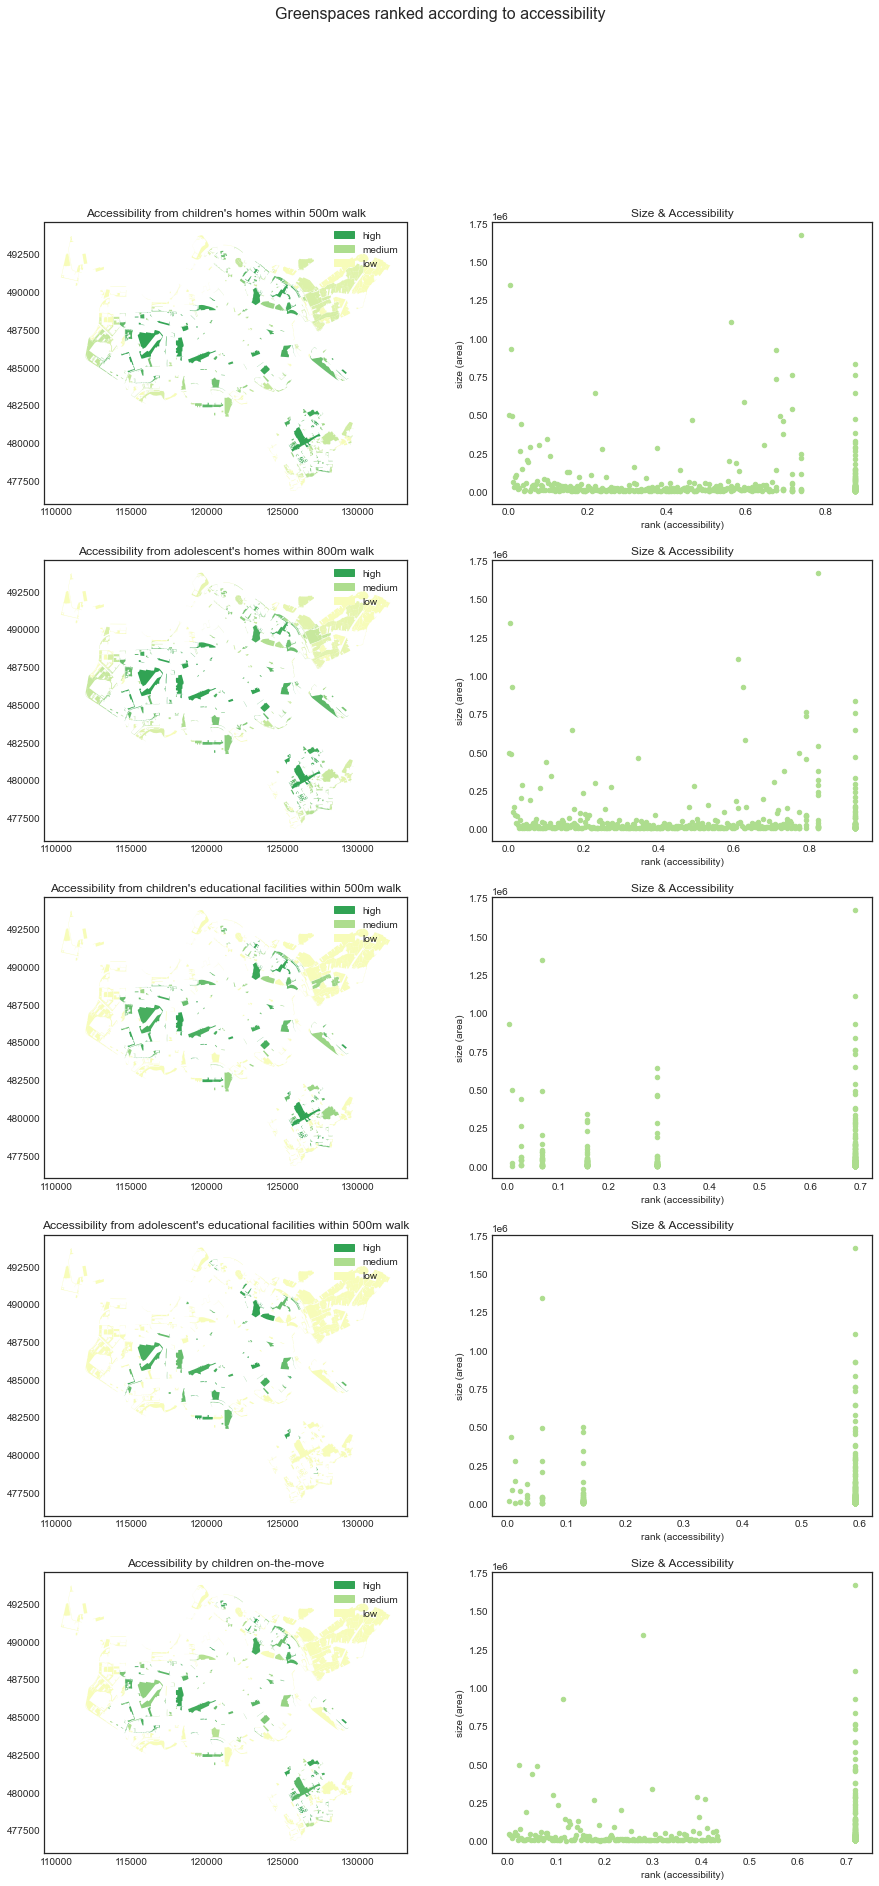

In [33]:
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(15,30))
fig.suptitle('Greenspaces ranked according to accessibility', fontsize=16)


handles = [
    mpatches.Patch(color='#31a354', label='high'),
    mpatches.Patch(color='#addd8e', label='medium'),
    mpatches.Patch(color='#f7fcb9', label='low')]
cmap = LinearSegmentedColormap.from_list('mycmap', [(0, '#31a354'), (0.5, '#addd8e'), (1, '#f7fcb9')])


greenspaces.plot(ax=axs[0,0], column='cld_count_sum_500_rank', cmap=cmap)
axs[0,0].set_title('Accessibility from children\'s homes within 500m walk')
axs[0,0].legend(handles=handles)
greenspaces.plot.scatter(ax=axs[0,1], x='cld_count_sum_500_rank', xlabel='rank (accessibility)', y='area', ylabel='size (area)', color='#addd8e')
axs[0,1].set_title('Size & Accessibility')

greenspaces.plot(ax=axs[1,0], column='adl_count_sum_800_rank', cmap=cmap)
axs[1,0].set_title('Accessibility from adolescent\'s homes within 800m walk')
axs[1,0].legend(handles=handles)
greenspaces.plot.scatter(ax=axs[1,1], x='adl_count_sum_800_rank', xlabel='rank (accessibility)', y='area', ylabel='size (area)', color='#addd8e')
axs[1,1].set_title('Size & Accessibility')

greenspaces.plot(ax=axs[2,0], column='educational_cld_count_500_rank', cmap=cmap)
axs[2,0].set_title('Accessibility from children\'s educational facilities within 500m walk')
axs[2,0].legend(handles=handles)
greenspaces.plot.scatter(ax=axs[2,1], x='educational_cld_count_500_rank', xlabel='rank (accessibility)', y='area', ylabel='size (area)', c='#addd8e')
axs[2,1].set_title('Size & Accessibility')

greenspaces.plot(ax=axs[3,0], column='educational_adl_count_500_rank', cmap=cmap)
axs[3,0].set_title('Accessibility from adolescent\'s educational facilities within 500m walk')
axs[3,0].legend(handles=handles)
greenspaces.plot.scatter(ax=axs[3,1], x='educational_adl_count_500_rank', xlabel='rank (accessibility)', y='area', ylabel='size (area)', c='#addd8e')
axs[3,1].set_title('Size & Accessibility')

greenspaces.plot(ax=axs[4,0], column='betw_cld_{}_dr12_entering_rank'.format(str(betw_radius)), cmap=cmap)
axs[4,0].set_title('Accessibility by children on-the-move')
axs[4,0].legend(handles=handles)
greenspaces.plot.scatter(ax=axs[4,1], x='betw_cld_{}_dr12_entering_rank'.format(str(betw_radius)), xlabel='rank (accessibility)', y='area', ylabel='size (area)', c='#addd8e')
axs[4,1].set_title('Size & Accessibility')


plt.show()

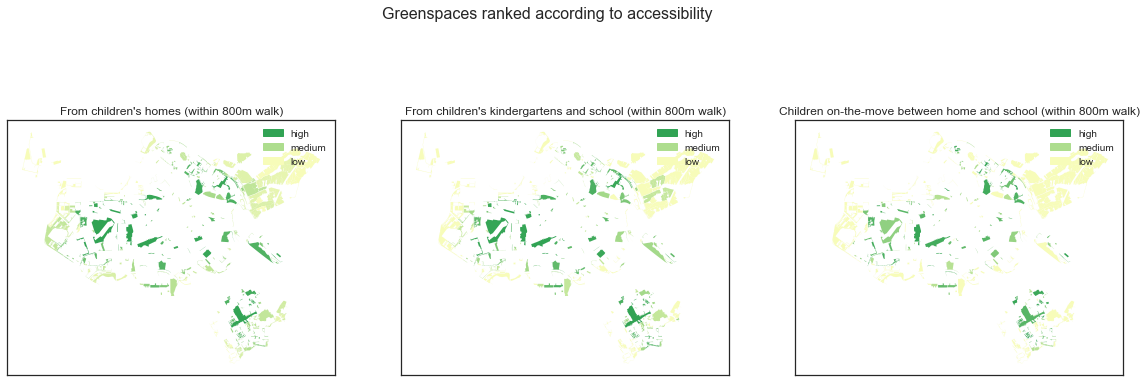

In [34]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20,7))
fig.suptitle('Greenspaces ranked according to accessibility', fontsize=16)


handles = [
    mpatches.Patch(color='#31a354', label='high'),
    mpatches.Patch(color='#addd8e', label='medium'),
    mpatches.Patch(color='#f7fcb9', label='low')]
cmap = LinearSegmentedColormap.from_list('mycmap', [(0, '#31a354'), (0.5, '#addd8e'), (1, '#f7fcb9')])


greenspaces.plot(ax=axs[0], column='cld_count_sum_800_rank', cmap=cmap)
axs[0].set_title('From children\'s homes (within 800m walk)')
axs[0].legend(handles=handles)


greenspaces.plot(ax=axs[1], column='educational_cld_count_800_rank', cmap=cmap)
axs[1].set_title('From children\'s kindergartens and school (within 800m walk)')
axs[1].legend(handles=handles)


greenspaces.plot(ax=axs[2], column='betw_cld_{}_dr12_entering_rank'.format(str(betw_radius)), cmap=cmap)
axs[2].set_title('Children on-the-move between home and school (within {}m walk)'.format(str(betw_radius)))
axs[2].legend(handles=handles)


for ax in axs:
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)



plt.show()

#  Store output data

In [35]:
output_sub_folder = os.path.join(input_output_folder, sub_folder)

In [36]:
if not os.path.exists(output_sub_folder):
    os.mkdir(output_sub_folder)

In [37]:
output_file = os.path.join(output_sub_folder, 'greenspace_accessibility.geojson')
greenspaces = greenspaces.apply(lambda c: c.astype(str) if c.name != "geometry" else c, axis=0)
greenspaces.to_file(output_file, driver='GeoJSON')